In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

import sys
from pathlib import Path
module_path = Path.cwd().parent / 'utils'
sys.path.append(str(module_path))
from simulations import *
import visualization

In [2]:
current_path = os.getcwd()  # Get current working directory
parent_path = os.path.dirname(current_path)

In [3]:
folder_path = parent_path +  '/dataset/Simulations_aug_indep_traincontrol/'  # change to your folder path
file_names = os.listdir(folder_path)
results_control = []
# Display the file names
for name in file_names:
    if 'results_survival_km_distance' in name:
        print(name)
        results_control.append(pd.read_csv(folder_path + name,index_col=0))
results_control = pd.concat(results_control)
results_control = results_control.sort_values(by='XP_num')

results_survival_km_distance_n_samples_600_n_features_bytype_6_MC_51to60.csv
results_survival_km_distance_n_samples_600_n_features_bytype_6_MC_11to20.csv
results_survival_km_distance_n_samples_600_n_features_bytype_6_MC_1to10.csv
results_survival_km_distance_n_samples_600_n_features_bytype_6_MC_71to80.csv
results_survival_km_distance_n_samples_600_n_features_bytype_6_MC_61to70.csv
results_survival_km_distance_n_samples_600_n_features_bytype_6_MC_81to90.csv
results_survival_km_distance_n_samples_600_n_features_bytype_6_MC_31to40.csv
results_survival_km_distance_n_samples_600_n_features_bytype_6_MC_91to100.csv
results_survival_km_distance_n_samples_600_n_features_bytype_6_MC_21to30.csv
results_survival_km_distance_n_samples_600_n_features_bytype_6_MC_41to50.csv


In [4]:
generators_sel = ["HI-VAE_weibull", "HI-VAE_piecewise", "HI-VAE_weibull_prior", 
                  "HI-VAE_piecewise_prior",
                  "Surv-GAN", "Surv-VAE"]

In [6]:
treat_effects_control = np.unique(results_control.H0_coef.values)
aug_percs = np.unique(results_control.aug_perc.values)
for col in results_control.columns:
    results_control[col] = np.float64(results_control[col].values)

# On all the generated datasets

### Train on control only

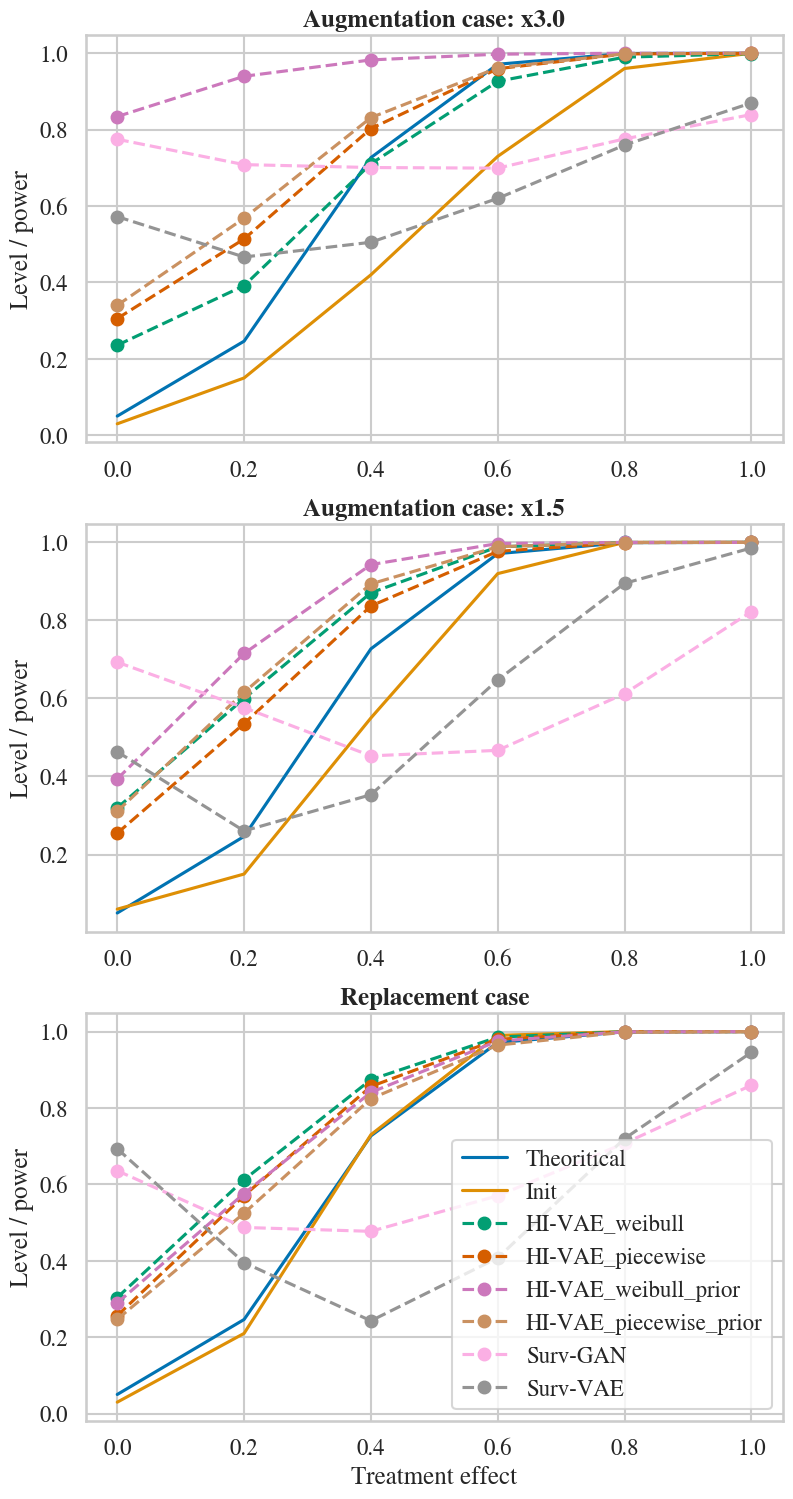

In [8]:
fig, axs = plt.subplots(len(aug_percs), 1, figsize=(9, 18))
for i, aug_perc in enumerate(aug_percs):
    results_ext_control = results_control[results_control.aug_perc == aug_perc].copy(deep=True)
    H0_coef_univ_theo = results_ext_control.groupby("H0_coef").mean()["H0_coef_univ"].to_numpy()
    D_control_theo = results_ext_control.groupby("H0_coef").mean()["D_control"].to_numpy()
    D_treated_theo = results_ext_control.groupby("H0_coef").mean()["D_treated"].to_numpy()
    power_theo = []
    for j in range(len(H0_coef_univ_theo)):
        power_theo.append(cpower(D_control_theo[j], D_treated_theo[j], H0_coef_univ_theo[j], 0.05))
    axs[i].plot(treat_effects_control, np.array(power_theo), label = "Theoritical")

    results_ext_control["reject_H0_init"] = results_ext_control['log_pvalue_init'] > -np.log(0.05)
    power_init = results_ext_control.groupby("H0_coef").mean()["reject_H0_init"].to_numpy()
    axs[i].plot(treat_effects_control, power_init, '-', label = "Init")

    custom_palette = ['deepskyblue', 'darkblue', 'orange', 'red']
    for generator_name in generators_sel:
        results_ext_control["reject_H0_gen_" + generator_name] = results_ext_control['log_pvalue_' + generator_name] > -np.log(0.05)
        power_gen = results_ext_control.groupby("H0_coef").mean()["reject_H0_gen_" + generator_name].to_numpy()
        axs[i].plot(treat_effects_control, power_gen, '--', marker='o', label = generator_name,)

    axs[i].set_ylabel("Level / power")
    if i < len(aug_percs)-1:
        axs[i].set_title("Augmentation case: x{}".format(1/(aug_perc)), fontweight="semibold")
    else: 
        axs[i].set_title("Replacement case", fontweight="semibold")
    plt.legend()    
plt.xlabel("Treatment effect")
plt.show()

# Only on the best generated dataset

### Train on control

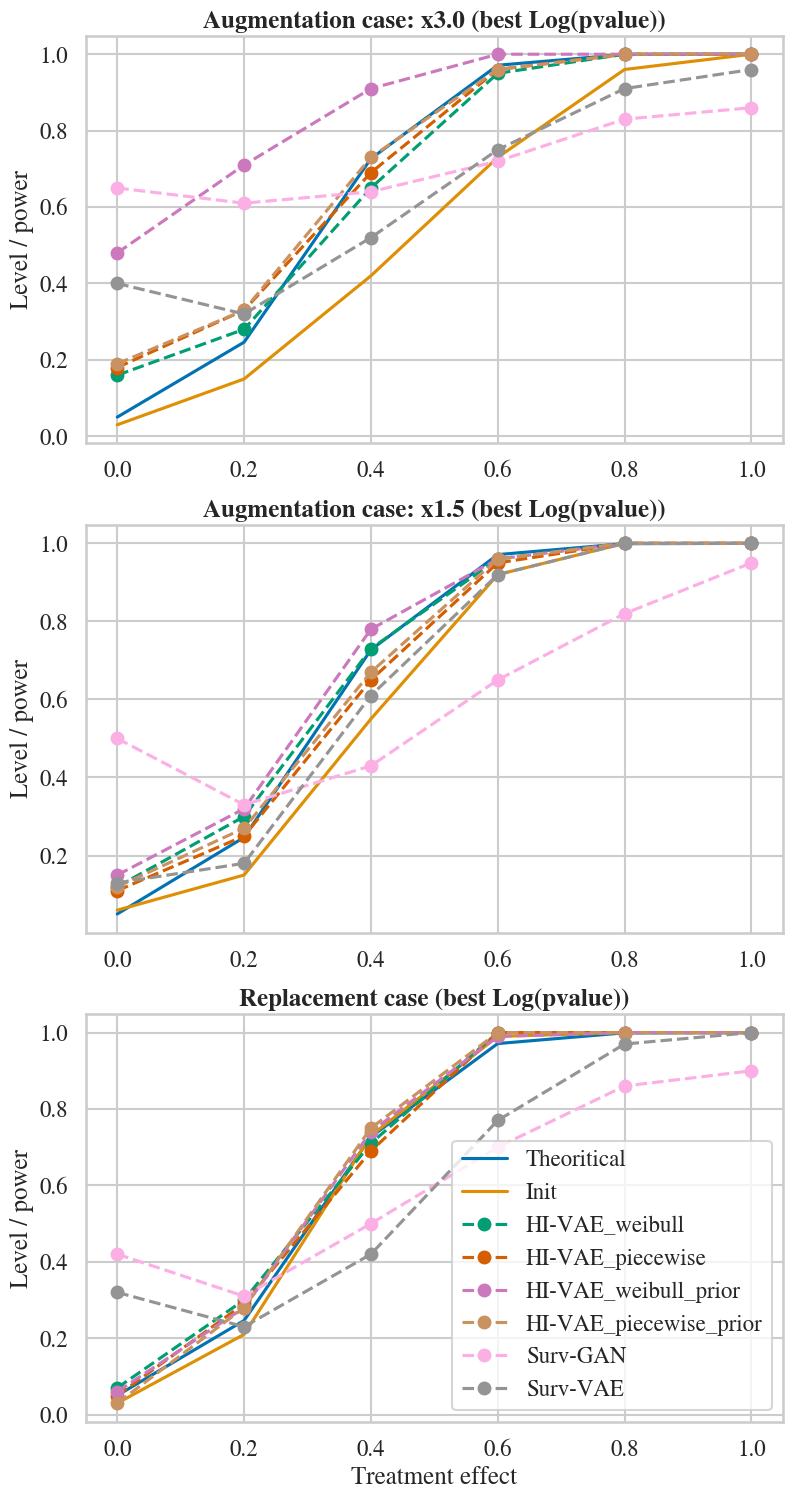

In [9]:
fig, axs = plt.subplots(len(aug_percs), 1, figsize=(9, 18))
for i, aug_perc in enumerate(aug_percs):
    results_ext_control = results_control[results_control.aug_perc == aug_perc].copy(deep=True)
    H0_coef_univ_theo = results_ext_control.groupby("H0_coef").mean()["H0_coef_univ"].to_numpy()
    D_control_theo = results_ext_control.groupby("H0_coef").mean()["D_control"].to_numpy()
    D_treated_theo = results_ext_control.groupby("H0_coef").mean()["D_treated"].to_numpy()
    power_theo = []
    for j in range(len(H0_coef_univ_theo)):
        power_theo.append(cpower(D_control_theo[j], D_treated_theo[j], H0_coef_univ_theo[j], 0.05))
    axs[i].plot(treat_effects_control, np.array(power_theo), label = "Theoritical")

    results_ext_control["reject_H0_init"] = results_ext_control['log_pvalue_init'] > -np.log(0.05)
    power_init = results_ext_control.groupby("H0_coef").mean()["reject_H0_init"].to_numpy()
    axs[i].plot(treat_effects_control, power_init, '-', label = "Init")

    custom_palette = ['deepskyblue', 'darkblue', 'orange', 'red']
    XP_num = np.unique(results_ext_control["XP_num"].values)
    for generator_name in generators_sel:
        results_MC_best_list = []
        for m in XP_num:
            results_MC = results_ext_control[results_ext_control["XP_num"] == m]
            best_metric = np.min(results_MC["log_pvalue_control_" + generator_name].values)
            results_MC_best = results_MC[results_MC["log_pvalue_control_" + generator_name] == best_metric].copy(deep=True)
            results_MC_best["reject_H0_gen_" + generator_name] = results_MC_best['log_pvalue_' + generator_name] > -np.log(0.05)
            results_MC_best_list.append(results_MC_best)
        power_gen = pd.concat(results_MC_best_list).groupby("H0_coef").mean()["reject_H0_gen_" + generator_name].to_numpy()
        axs[i].plot(treat_effects_control, power_gen, '--', marker='o', label = generator_name,)

    axs[i].set_ylabel("Level / power")
    if i < len(aug_percs)-1:
        axs[i].set_title("Augmentation case: x{} (best Log(pvalue))".format(1/(aug_perc)), fontweight="semibold")
    else: 
        axs[i].set_title("Replacement case (best Log(pvalue))", fontweight="semibold")
    plt.legend()    
plt.xlabel("Treatment effect")
plt.show()

# Synthcity metric: all generated datasets

### Train on control 

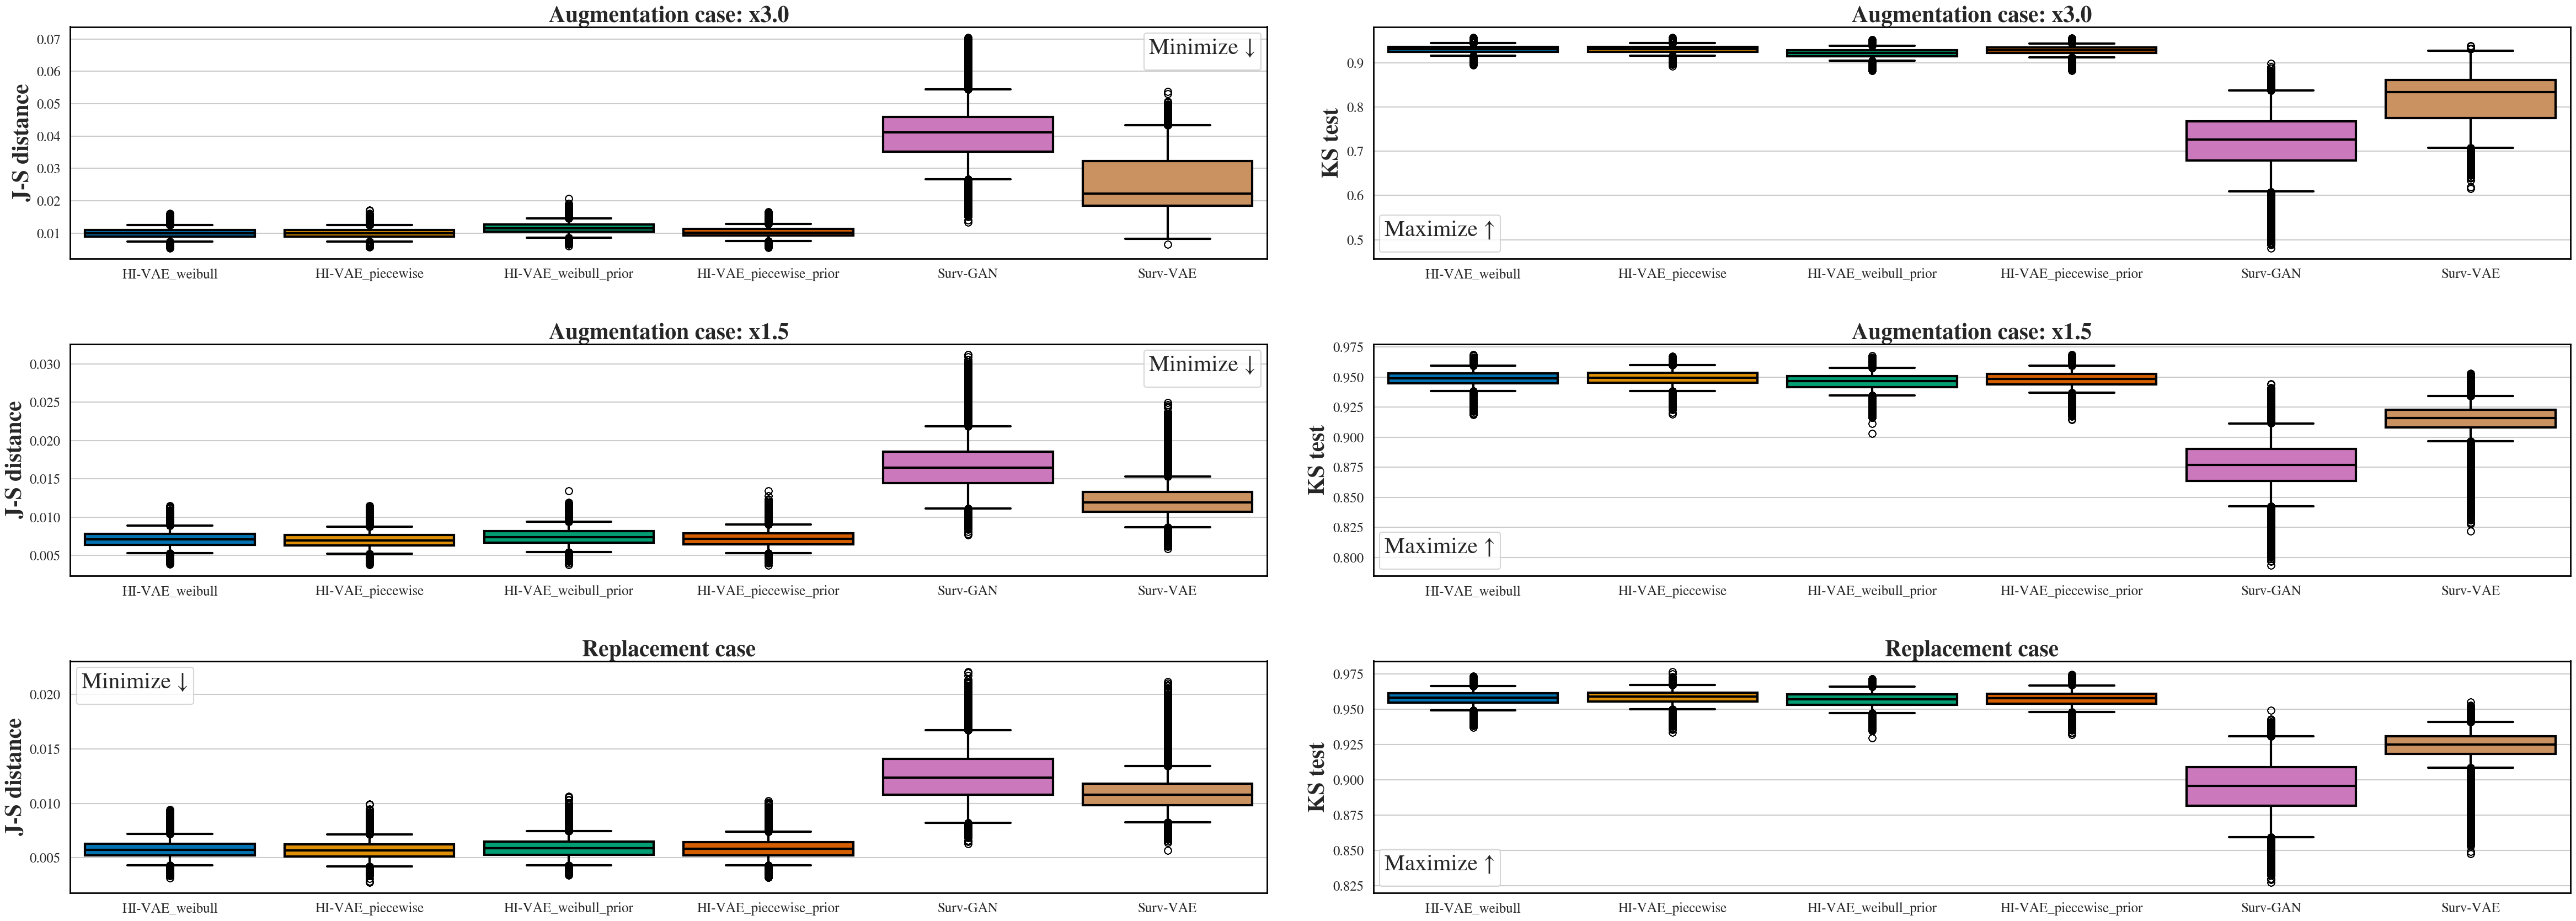

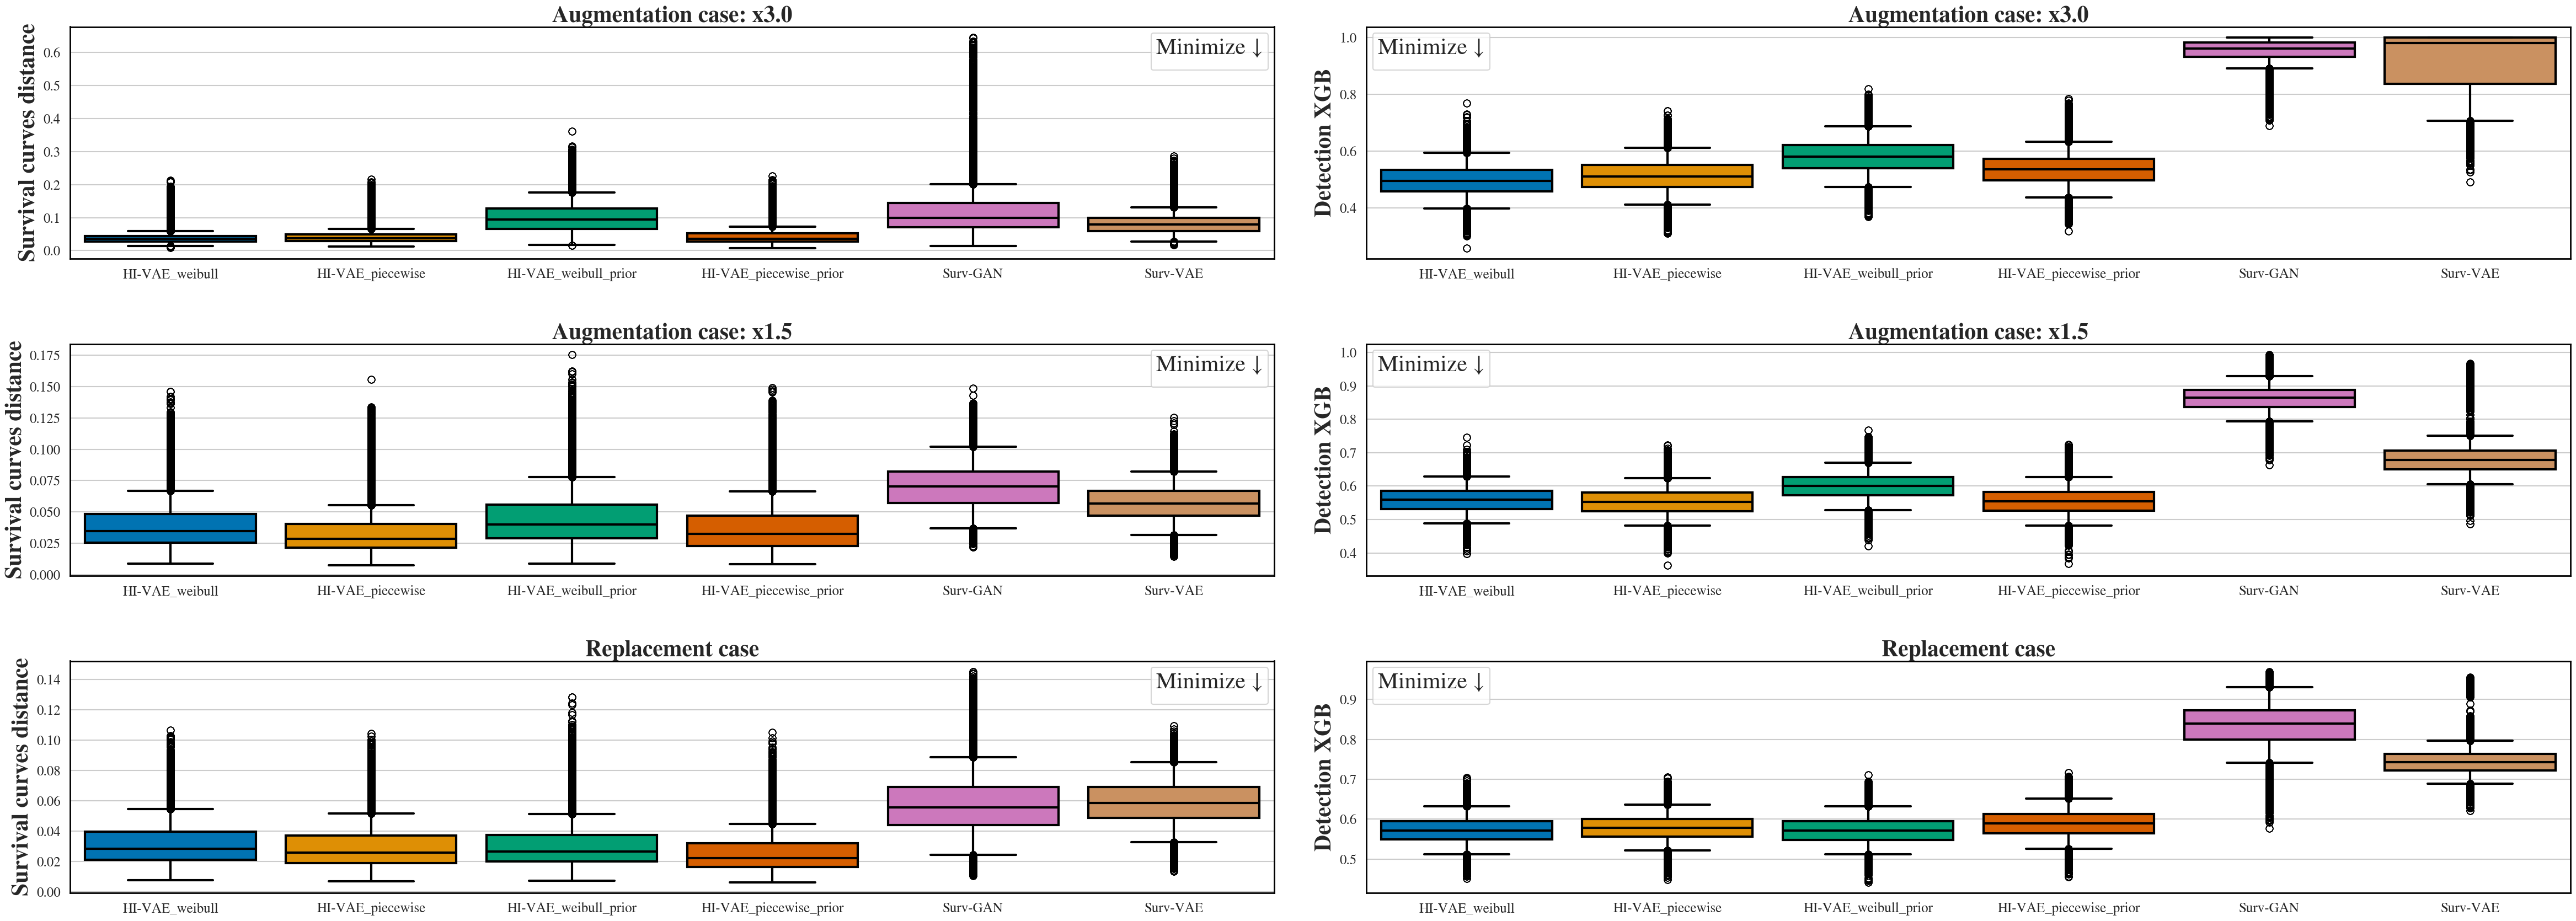

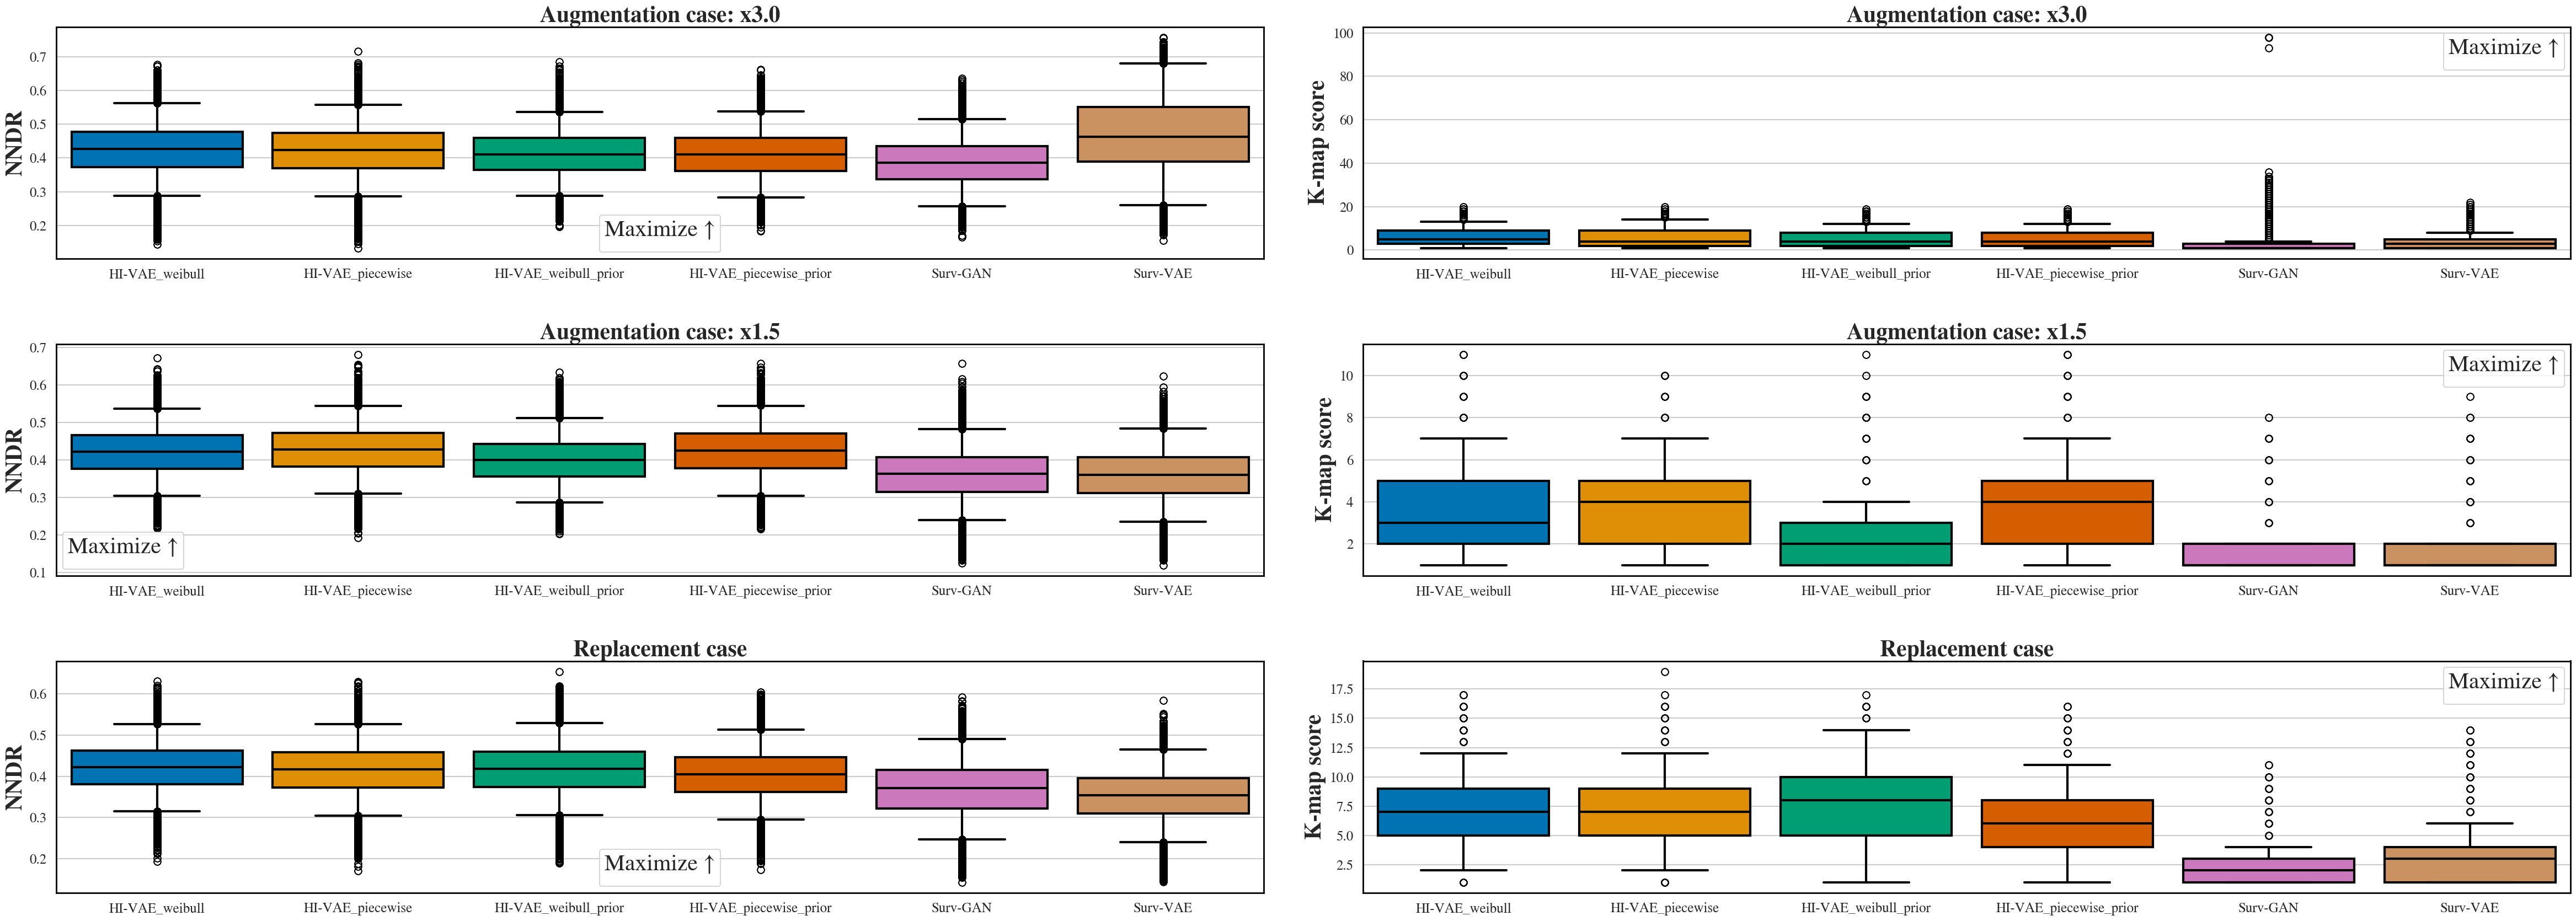

In [10]:
#### SYNTHCITY METRICS 
# metrics=[['J-S distance', "min"], ['KS test', "max"]]
metrics = [[['J-S distance', "min"], ['KS test', "max"]],
                [['Survival curves distance', "min"], ['Detection XGB', "min"]],
                [['NNDR', "max"], ['K-map score', "max"]]]

for sub_metrics in metrics:
    num_metrics = len(sub_metrics)
    n_learners = len(generators_sel)
    fig, axs = plt.subplots(len(aug_percs), num_metrics, figsize=(4 * num_metrics * n_learners, 6 * len(aug_percs)))

    if num_metrics == 1:
        axs = [axs]  # ensure axs is iterable

    for i, aug_perc in enumerate(aug_percs):
        results_ext_control = results_control[results_control.aug_perc == aug_perc].copy(deep=True)
        for j, ax in enumerate(axs[i]):
            # Format axis spines
            metric_name, opt = sub_metrics[j]
            metric_df = pd.DataFrame()
            for generator_name in generators_sel:
                metric_df = pd.concat([metric_df, pd.DataFrame(np.array([[generator_name] * results_ext_control.shape[0], 
                                                                results_ext_control[metric_name + "_" + generator_name]]).T,
                                                                columns=['generator', metric_name])])
            metric_df[metric_name] = np.float64(metric_df[metric_name].values)
            for spine in ax.spines.values():
                spine.set_linewidth(2)
                spine.set_edgecolor('black')

            sns.boxplot(data=metric_df, x='generator', y=metric_name, ax=ax,
                        linewidth = 3, saturation = 1, palette = 'colorblind', 
                        width = 1, gap = 0.15, whis = 0.8, linecolor="Black")
            ax.set_xlabel('')
            ax.set_ylabel(metric_name, fontsize=30, fontweight="semibold")
            # ax.set_title("Drop level {}".format(aug_perc), fontsize=20, fontweight="semibold")
            if i < len(aug_percs)-1:
                ax.set_title("Augmentation case: x{}".format(1/(aug_perc)), fontsize=30, fontweight="semibold")
            else: 
                ax.set_title("Replacement case", fontsize=30, fontweight="semibold")
            ax.tick_params(axis='x', labelsize=18)
            ax.tick_params(axis='y', labelsize=18)
            if opt == "max":
                ax.legend(title='Maximize \u2191', title_fontsize=30)
            else:
                ax.legend(title='Minimize \u2193', title_fontsize=30)
    plt.tight_layout(pad=3)
# plt.savefig("./dataset/" + dataset_name + "/results_synthetic_metrics_independent_n_samples_" + str(n_samples) + "n_features_bytype_" + str(n_features_bytype) + ".jpeg")

# Synthcity metrics: only best generated control dataset for each MC experiment

### Train on control

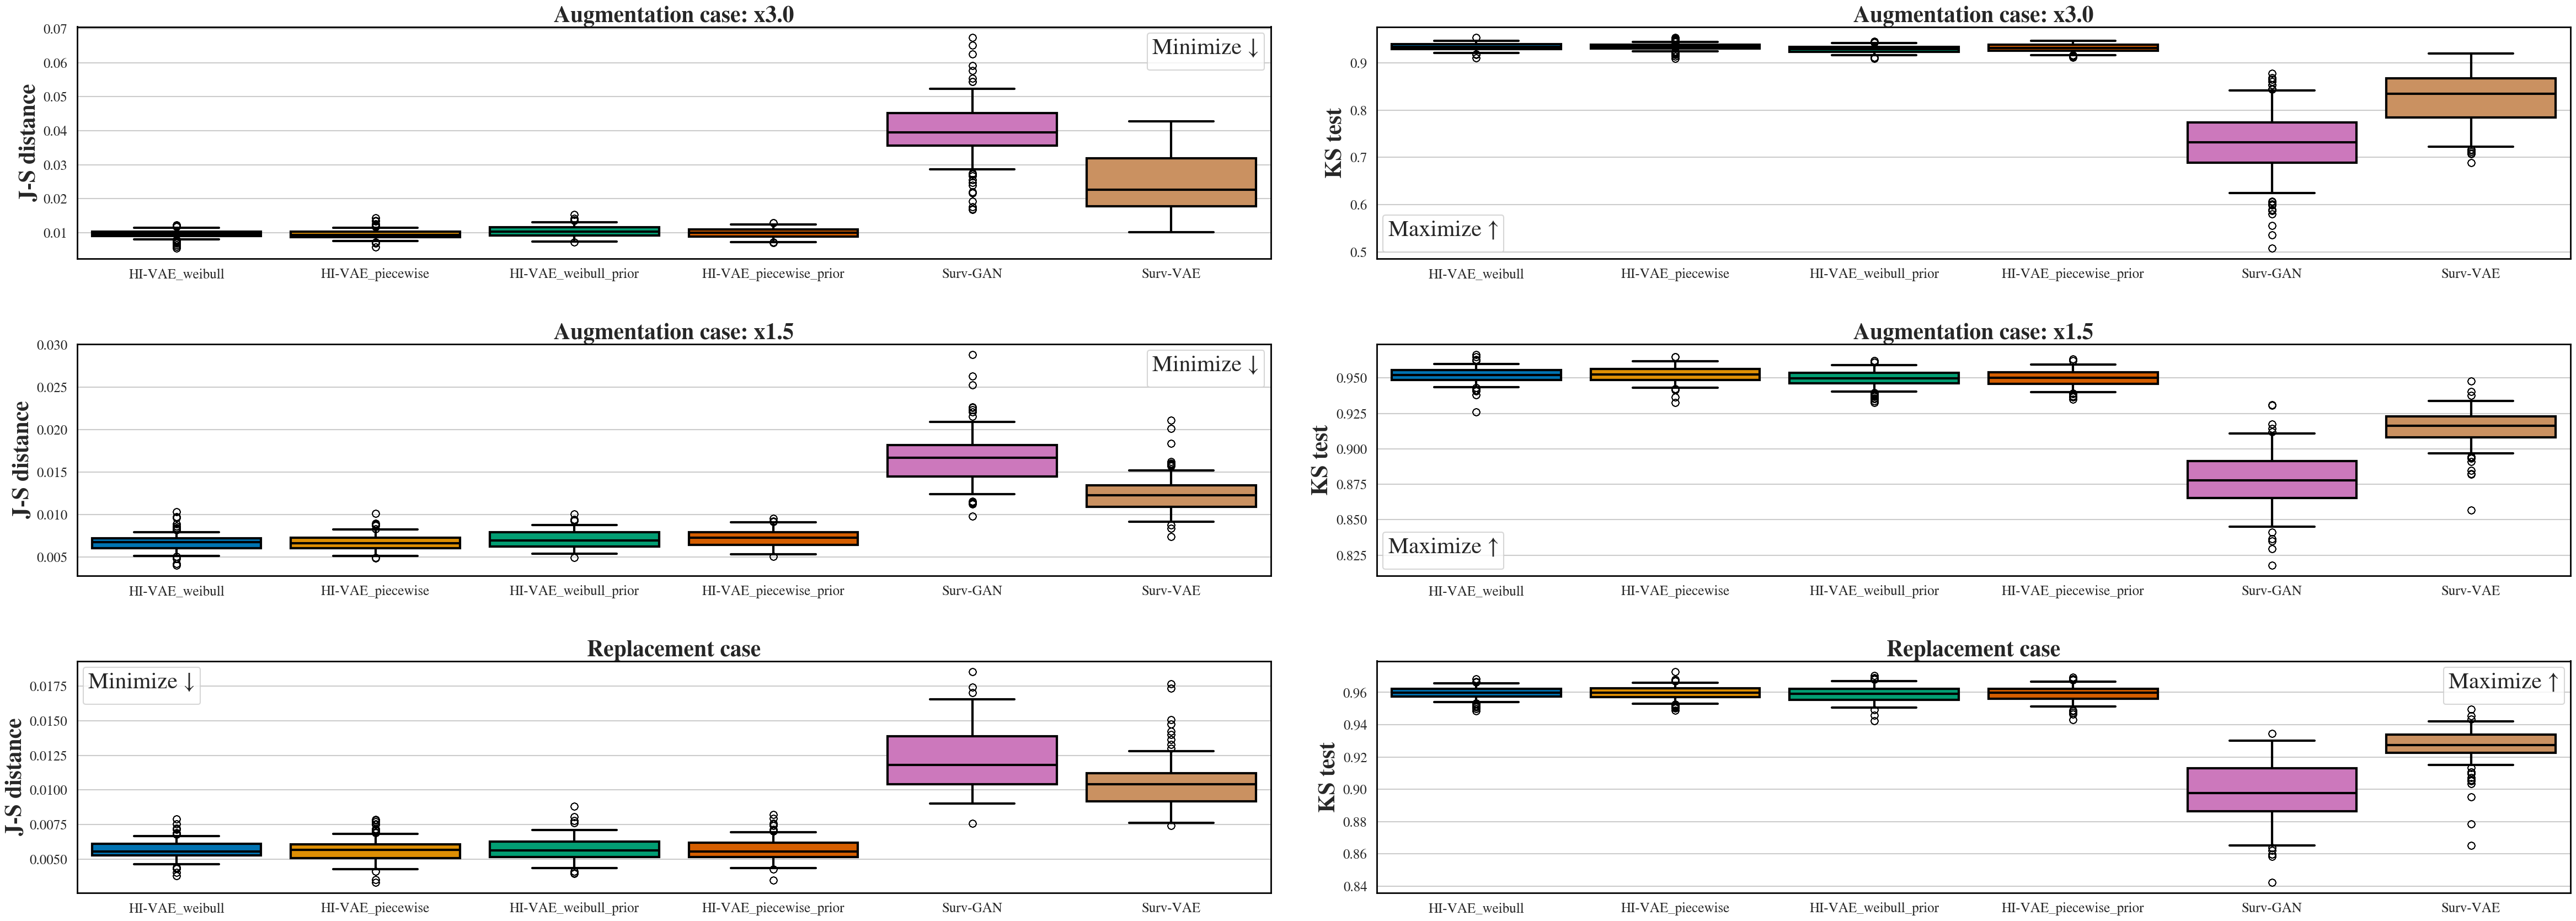

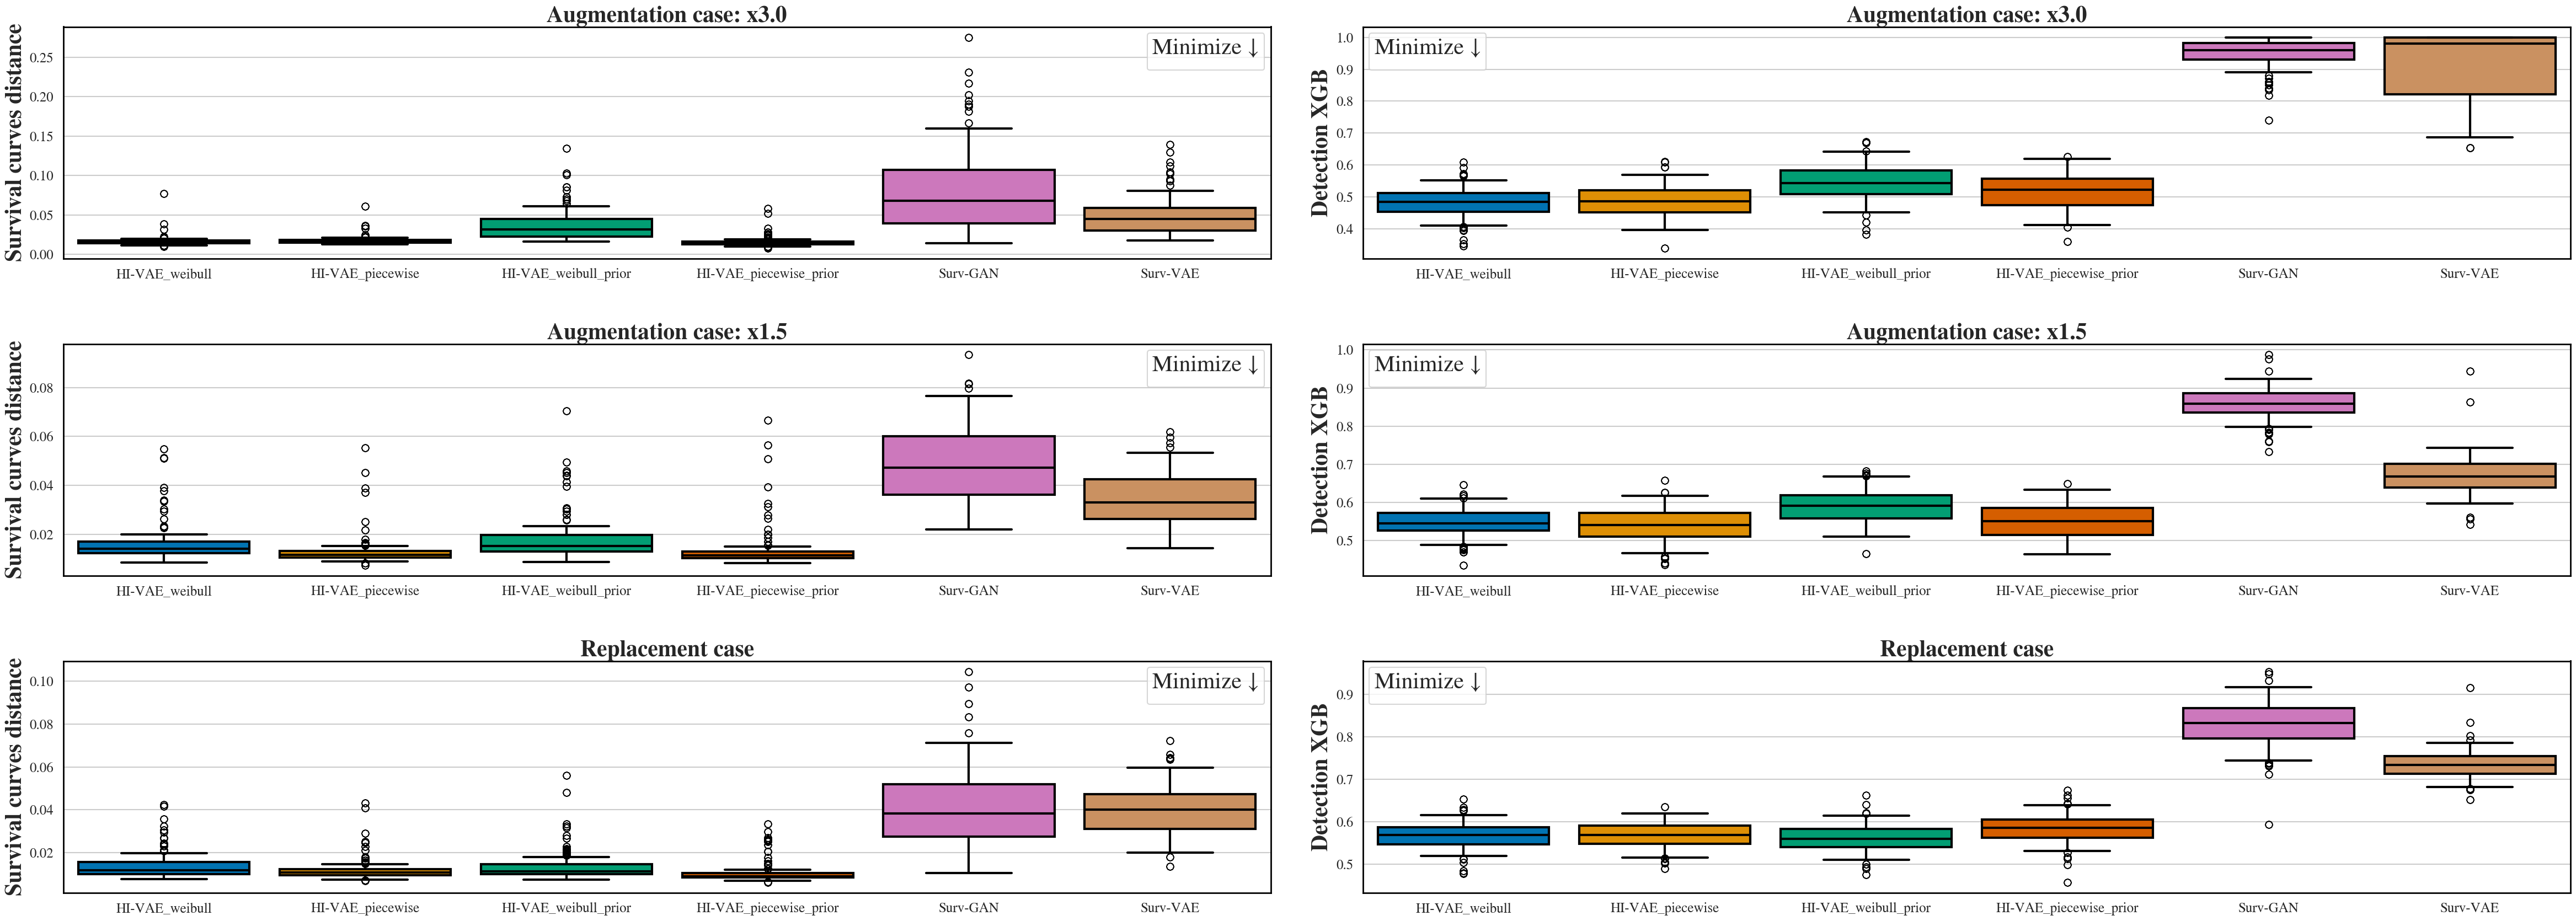

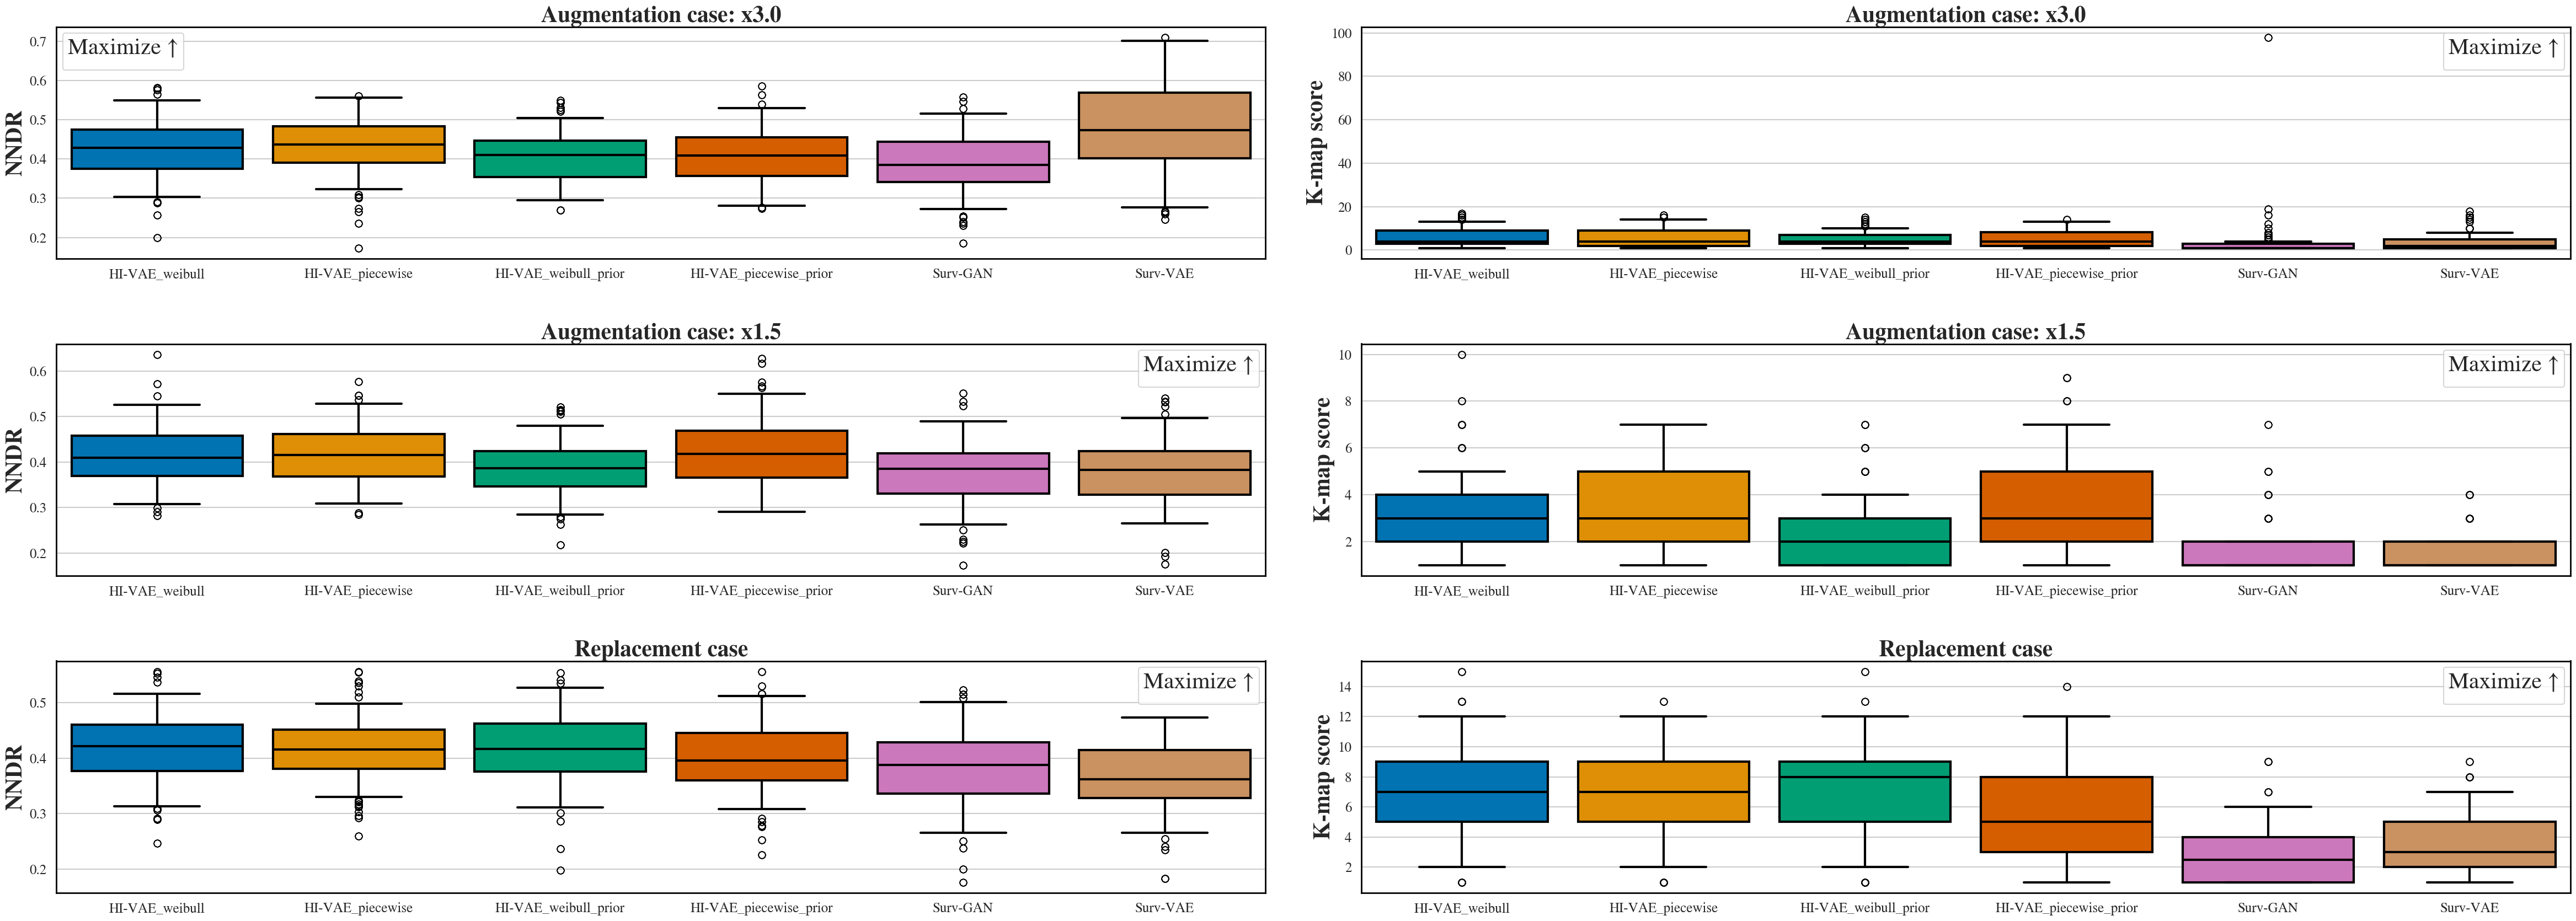

In [11]:
#### SYNTHCITY METRICS 
# metrics=[['J-S distance', "min"], ['KS test', "max"]]
metrics = [[['J-S distance', "min"], ['KS test', "max"]],
                [['Survival curves distance', "min"], ['Detection XGB', "min"]],
                [['NNDR', "max"], ['K-map score', "max"]]]

for sub_metrics in metrics:
    num_metrics = len(sub_metrics)
    n_learners = len(generators_sel)
    fig, axs = plt.subplots(len(aug_percs), num_metrics, figsize=(4 * num_metrics * n_learners, 6 * len(aug_percs)))

    if num_metrics == 1:
        axs = [axs]  # ensure axs is iterable

    for i, aug_perc in enumerate(aug_percs):
        results_ext_control = results_control[results_control.aug_perc == aug_perc].copy(deep=True)
        for j, ax in enumerate(axs[i]):
            # Format axis spines
            metric_name, opt = sub_metrics[j]
            metric_df = pd.DataFrame()
            XP_num = np.unique(results_ext_control["XP_num"].values)
            for m in XP_num:
                results_MC = results_ext_control[results_ext_control["XP_num"] == m]
                for generator_name in generators_sel:
                    best_metric = np.min(results_MC["Survival curves distance_" + generator_name].values)
                    results_MC_best = results_MC[results_MC["Survival curves distance_" + generator_name] == best_metric]
                    metric_df = pd.concat([metric_df, pd.DataFrame(np.array([[generator_name] * results_MC_best.shape[0], 
                                                                    results_MC_best[metric_name + "_" + generator_name]]).T,
                                                                    columns=['generator', metric_name])])
            metric_df[metric_name] = np.float64(metric_df[metric_name].values)
            for spine in ax.spines.values():
                spine.set_linewidth(2)
                spine.set_edgecolor('black')

            sns.boxplot(data=metric_df, x='generator', y=metric_name, ax=ax,
                        linewidth = 3, saturation = 1, palette = 'colorblind', 
                        width = 1, gap = 0.15, whis = 0.8, linecolor="Black")
            ax.set_xlabel('')
            ax.set_ylabel(metric_name, fontsize=30, fontweight="semibold")
            # ax.set_title("Drop level {}".format(aug_perc), fontsize=20, fontweight="semibold")
            if i < len(aug_percs)-1:
                ax.set_title("Augmentation case: x{}".format(1/(aug_perc)), fontsize=30, fontweight="semibold")
            else: 
                ax.set_title("Replacement case", fontsize=30, fontweight="semibold")
            ax.tick_params(axis='x', labelsize=18)
            ax.tick_params(axis='y', labelsize=18)
            if opt == "max":
                ax.legend(title='Maximize \u2191', title_fontsize=30)
            else:
                ax.legend(title='Minimize \u2193', title_fontsize=30)

    plt.tight_layout(pad=3)
# plt.savefig("./dataset/" + dataset_name + "/results_synthetic_metrics_independent_n_samples_" + str(n_samples) + "n_features_bytype_" + str(n_features_bytype) + ".jpeg")

# Other metrics

### Train on control

[KeOps] Warning : omp.h header is not in the path, disabling OpenMP. To fix this, you can set the environment
                  variable OMP_PATH to the location of the header before importing keopscore or pykeops,
                  e.g. using os.environ: import os; os.environ['OMP_PATH'] = '/path/to/omp/header'
[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode
Augmentation case: x3.0


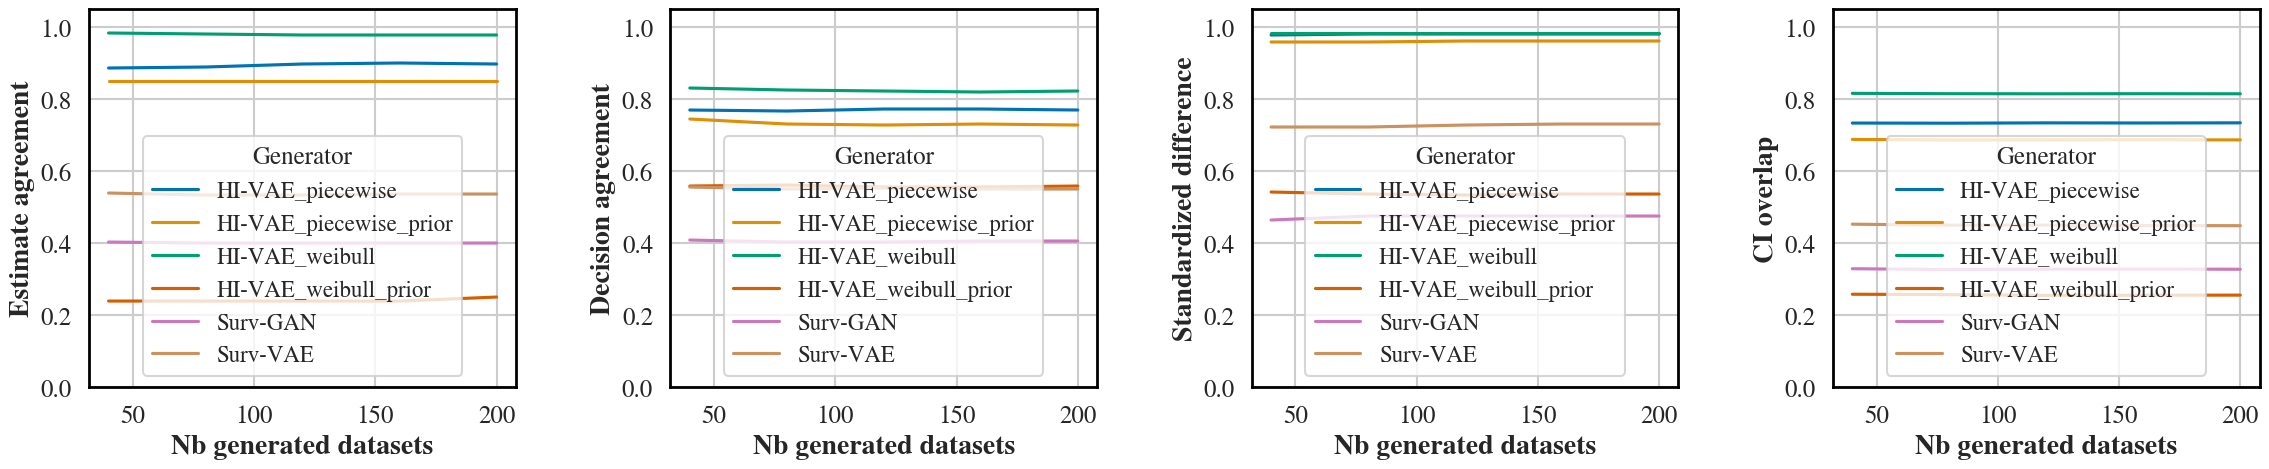

Augmentation case: x1.5


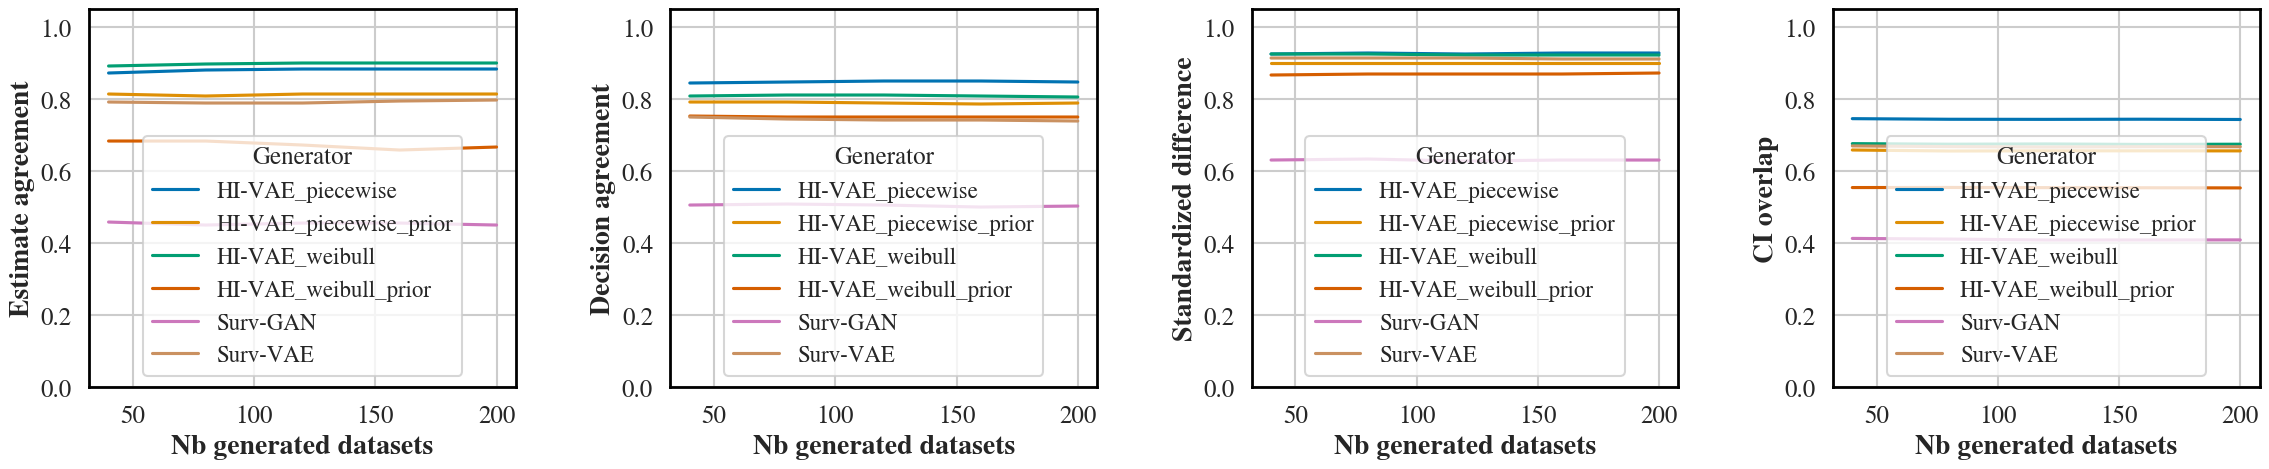

Replacement case


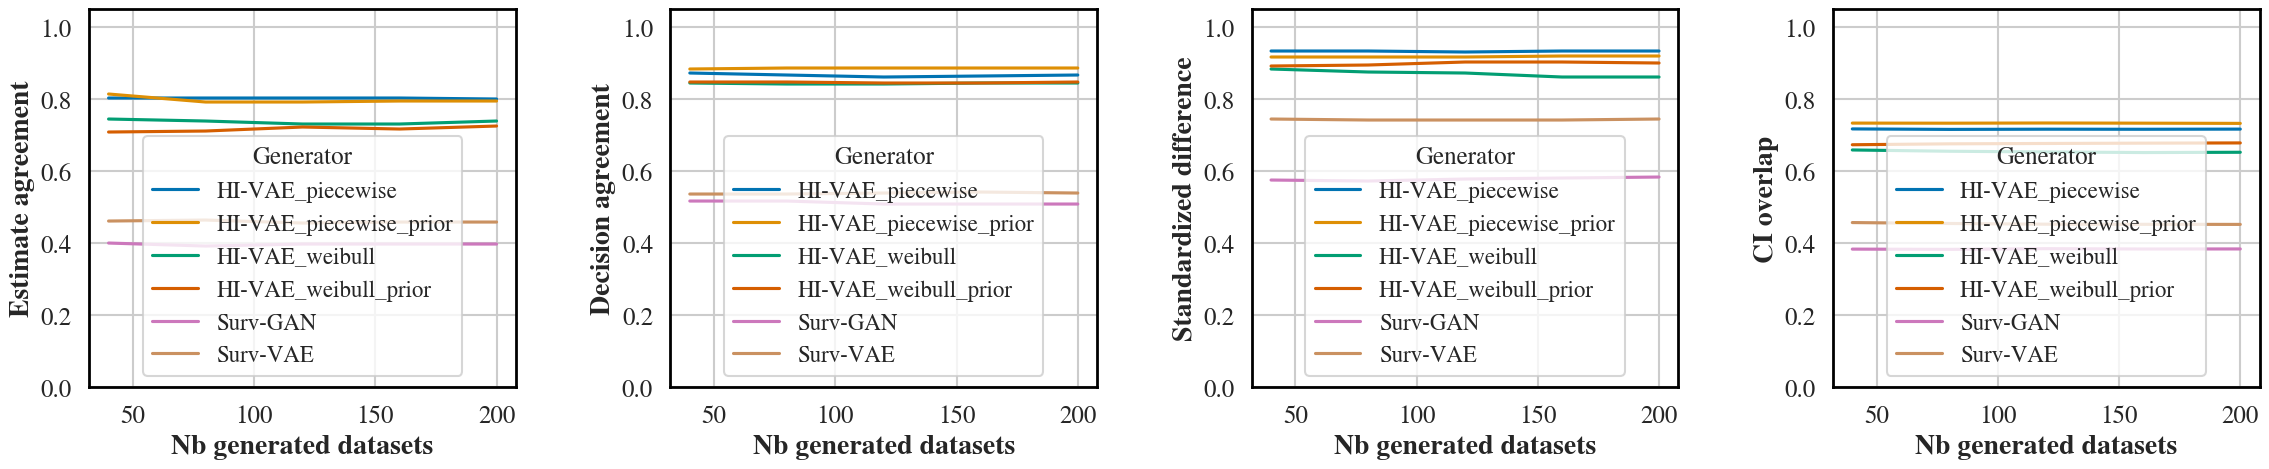

In [12]:
n_MC_exp = 60
from metrics import estimate_agreement, decision_agreement, standardized_difference, ci_overlap
columns = ['time', 'censor', 'treatment']

from visualization import visualize_replicability_perf
# score_df = pd.DataFrame(columns=["Generator", "Treatment_effect", "MC_exp", "Nb generated datasets", "Estimate agreement", "Decision agreement", "Standardized difference", "CI overlap"])
for i, aug_perc in enumerate(aug_percs):
    results_ext_control = results_control[results_control.aug_perc == aug_perc].copy(deep=True)
    score_df = pd.DataFrame(columns=["Generator", "Nb generated datasets", "Estimate agreement", "Decision agreement", "Standardized difference", "CI overlap"])
    for treatment_effect in treat_effects_control:
        results_treat = results_ext_control[results_ext_control.H0_coef == treatment_effect]
        cox_init = results_treat[["est_cox_coef_init", "est_cox_coef_se_init"]].drop_duplicates().values
        for m in range(n_MC_exp):
            results_MC = results_treat[(results_treat[["est_cox_coef_init", "est_cox_coef_se_init"]] == cox_init[m]).all(axis=1)]
            coef_init, se_init = results_MC[["est_cox_coef_init", "est_cox_coef_se_init"]].drop_duplicates().values[0]
            ci_init = (coef_init - 1.96 * se_init, coef_init + 1.96 * se_init)

            for generator in generators_sel:
                coef_syn, se_syn = results_MC[["est_cox_coef_" + generator, "est_cox_coef_se_" + generator]].values.T
                max_len_samples = len(coef_syn)
                list_len_samples = np.arange(int(.2 * max_len_samples), max_len_samples, int(.2 * max_len_samples)).tolist()
                if max_len_samples not in list_len_samples:
                    list_len_samples += [max_len_samples]
                for j in list_len_samples:
                    coef_syn_, se_syn_ = np.array(coef_syn)[:j], np.array(se_syn)[:j]
                    coef_syn_mean = coef_syn_.mean()
                    var_syn_mean = (se_syn_**2).mean()
                    # imputation_var_syn = (1 / (len(coef_syn) - 1)) * np.sum([(coef_syn_ - coef_syn_mean)**2 for coef_syn_ in coef_syn])
                    # adjusted_var_syn = (imputation_var_syn / len(coef_syn)) + var_syn_mean
                    adjusted_var_syn = (1/j + 1) * var_syn_mean
                    ci_syn = (coef_syn_mean - 1.96 * np.sqrt(adjusted_var_syn), coef_syn_mean + 1.96 * np.sqrt(adjusted_var_syn))

                    res = [estimate_agreement(ci_init, coef_syn_mean),
                        decision_agreement(coef_init, ci_init, coef_syn_mean, ci_syn),
                        standardized_difference(coef_init, coef_syn_mean, se_init),
                        ci_overlap(ci_init, ci_syn)]

                    # score_df.loc[len(score_df)] = [generator, treatment_effect, m, j] + res
                    score_df.loc[len(score_df)] = [generator, j] + res
    if i < len(aug_percs)-1:
        print("Augmentation case: x{}".format(1/(aug_perc)))
    else:               
        print("Replacement case")
    visualize_replicability_perf(score_df.groupby(['Generator', 'Nb generated datasets'], as_index=False).mean())